### Construction materials price estimation using Autoencoder and Deep neural network

In [16]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt

import tensorflow as tf

In [17]:
def load_process_data(data_file, sheet_name, test_size, random_state=True):

    """
    Load excel data file, Standardize data with mean of 0.0 and standard deviation of 1.0
    and split data into traininig and test sets

    Args:
    data_file: path to excel data file
    sheet_name: excel sheet to load and process e.g (Cement, Steel or Reinforcement)
    test_size (float): percentage of test size
    random_state: Controls the shuffling applied to the data before applying the split.
        Pass an int for reproducible output across multiple function calls
    """

    global Xscaler
    global Yscaler
    
    data = pd.read_excel(data_file, sheet_name=sheet_name)

    data_X = data.iloc[:, 2:-1]
    data_Y = data.iloc[:, -1]

    Xscaler = preprocessing.StandardScaler().fit(data_X.to_numpy())
    X_data = Xscaler.transform(data_X.to_numpy(dtype=np.float32))

    Yscaler = preprocessing.StandardScaler().fit(data_Y.to_numpy().reshape(-1, 1))
    Y_data = Yscaler.transform(data_Y.to_numpy(dtype=np.float32).reshape(-1, 1))

    if random_state:
        X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=test_size, random_state=1000)
    else:
        X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=test_size)

    return X_train, X_test, Y_train, Y_test, X_data

In [18]:
X_train, X_test, Y_train, Y_test, X_data = load_process_data('Data for modelling.xlsx', 'Reinforcement', .15)

In [19]:
X_train.shape, X_test.shape, X_data.shape

((102, 12), (18, 12), (120, 12))

### Autoencoder

In [20]:
class AutoEncoder(tf.keras.Model):
    def __init__(self, n_hidden_1, n_hidden_2, encoding_layer, n_input):
        super(AutoEncoder, self).__init__()

        self.n_hidden_1 = n_hidden_1 # 1st layer num features
        self.n_hidden_2 = n_hidden_2 # 2nd layer num features
        self.encoding_layer = encoding_layer
        self.n_input = n_input 

        
        self.enocoding_1 = tf.keras.layers.Dense(self.n_hidden_1, activation=tf.nn.relu)
        self.encoding_2 = tf.keras.layers.Dense(self.n_hidden_2, activation=tf.nn.relu)
        self.encoding_final = tf.keras.layers.Dense(self.encoding_layer, activation=tf.nn.relu)
        self.decoding_1 = tf.keras.layers.Dense(self.n_hidden_2, activation=tf.nn.relu)
        self.decoding_2 = tf.keras.layers.Dense(self.n_hidden_1, activation=tf.nn.relu)
        self.decoding_final = tf.keras.layers.Dense(self.n_input)


    # Building the encoder
    def encoder(self,x):
        layer_1 = self.enocoding_1(x)
        layer_2 = self.encoding_2(layer_1)
        code = self.encoding_final(layer_2)
        return code
        

    # Building the decoder
    def decoder(self, x):
        layer_1 = self.decoding_1(x)
        layer_2 = self.decoding_2(layer_1)
        decode = self.decoding_final(layer_2)
        return decode

        
    def call(self, x):
        encoder_op  = self.encoder(x)
        y_pred = self.decoder(encoder_op)
        return y_pred, encoder_op
        
def cost(y_true, y_pred):
    """
    Calculate cost after each epoch
    """
    loss = tf.losses.mean_squared_error(y_true, y_pred)     # get loss for each forward pass
    cost = tf.reduce_mean(loss)                             # and the cost as the mean of all losses in an epoch/batch
    return cost

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:    
        reconstruction, encoder_last = model(inputs)
        loss_value = cost(targets, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), reconstruction, encoder_last

In [21]:
def BPNN_model(learning_rate=0.005):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation=tf.nn.tanh),       # 1st layer with 64 nuerons
        tf.keras.layers.Dropout(.25),                           # drop out layer for regularization
        tf.keras.layers.Dense(32, activation=tf.nn.tanh),
        tf.keras.layers.Dense(8, activation=tf.nn.tanh),
        tf.keras.layers.Dense(1),                               # output layer with 1 nueron for cost prediction (linear regression)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.mean_squared_error)

    return model

In [22]:
def train_BPNN_model(model, train_data, validation_data, encoder, epochs, batch_size):
    """
    Use trained encoder and extract features to tarin Back Propagation neural network

    Args:
    model: BPNN model
    train_data: tuple of (training_features, training_targets)
    validation_data: tuple of (validation_features, validation_targets)
    encoder: trained encoder
    epochs: int
    batch_size: int
    """

    train_features = encoder(train_data[0])
    test_features = encoder(validation_data[0])

    # train_features = preprocessing.StandardScaler().fit_transform(train_features)
    # test_features = preprocessing.StandardScaler().fit_transform(test_features)

    model.fit(train_features, train_data[1], epochs=epochs, batch_size=batch_size, validation_data=(test_features, validation_data[1]))

    return model

In [23]:
# hyper parameters
learning_rate = 0.01
training_epochs = 100
batch_size = 32
display_step = 1
total_batch = int(X_train.shape[0] / batch_size)

# Network Parameters
n_hidden_1 = 32 # 1st layer num features
n_hidden_2 = 24 # 2nd layer num features
encoding_layer = 8 # final encoding bottleneck features
n_input = X_train.shape[1]

In [24]:
# instantiate models
autoEncoder = AutoEncoder(n_hidden_1, n_hidden_2, encoding_layer, n_input)
model_BPNN = BPNN_model()

optimizer = tf.keras.optimizers.Adam(learning_rate)

autoEncoder.build(X_train.shape)
# autoEncoder.summary()

In [25]:
loss = []

# train Autoencoder
for epoch in range(training_epochs):
    
    for batch in range(total_batch):
        x_inp = X_data[batch : batch + batch_size]
    
        loss_value, grads, reconstruction, _ = grad(autoEncoder, x_inp, x_inp)
        optimizer.apply_gradients(zip(grads, autoEncoder.trainable_variables))

    loss.append(loss_value)
            
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(loss_value))


# train BPNN using extracted features from autoEncoder's encoder
model_BPNN = train_BPNN_model(model_BPNN, (X_train, Y_train), (X_test, Y_test), autoEncoder.encoder, epochs=1000, batch_size=batch_size)

Epoch: 0001 cost= 0.906727612
Epoch: 0002 cost= 0.492718309
Epoch: 0003 cost= 0.374018341
Epoch: 0004 cost= 0.304361701
Epoch: 0005 cost= 0.252214402
Epoch: 0006 cost= 0.193499118
Epoch: 0007 cost= 0.144383997
Epoch: 0008 cost= 0.111415975
Epoch: 0009 cost= 0.090547308
Epoch: 0010 cost= 0.074095950
Epoch: 0011 cost= 0.060862422
Epoch: 0012 cost= 0.053720683
Epoch: 0013 cost= 0.049281076
Epoch: 0014 cost= 0.046091732
Epoch: 0015 cost= 0.043742537
Epoch: 0016 cost= 0.041824102
Epoch: 0017 cost= 0.040406935
Epoch: 0018 cost= 0.038743876
Epoch: 0019 cost= 0.036928404
Epoch: 0020 cost= 0.035253495
Epoch: 0021 cost= 0.033764873
Epoch: 0022 cost= 0.032793667
Epoch: 0023 cost= 0.031851865
Epoch: 0024 cost= 0.031077150
Epoch: 0025 cost= 0.030454848
Epoch: 0026 cost= 0.030067179
Epoch: 0027 cost= 0.029707834
Epoch: 0028 cost= 0.029394036
Epoch: 0029 cost= 0.029178064
Epoch: 0030 cost= 0.028977152
Epoch: 0031 cost= 0.028776892
Epoch: 0032 cost= 0.028560160
Epoch: 0033 cost= 0.028324839
Epoch: 003

2022-11-24 12:35:49.552251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 100ms/step - loss: 1.0370 - val_loss: 0.5473
Epoch 2/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.5350 - val_loss: 0.3857
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3752 - val_loss: 0.3332
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.3731 - val_loss: 0.2651
Epoch 5/1000


2022-11-24 12:35:49.938787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 13ms/step - loss: 0.2327 - val_loss: 0.2425
Epoch 6/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.2153 - val_loss: 0.2580
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2192 - val_loss: 0.2587
Epoch 8/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1918 - val_loss: 0.2433
Epoch 9/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1895 - val_loss: 0.2307
Epoch 10/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1723 - val_loss: 0.2219
Epoch 11/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1860 - val_loss: 0.2240
Epoch 12/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1840 - val_loss: 0.2149
Epoch 13/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1561 - val_loss: 0.2008
Epoch 14/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1619 - val_loss: 0.1953
Epoch 15/1000
4/4 

In [26]:
# Function to plot loss
def plot_loss(loss, val_loss=None):
    plt.plot(loss, label='loss')
    if val_loss:
        plt.plot(val_loss, label='val_loss')
    plt.ylim([0,1])
    plt.xlabel('Epoch')
    plt.ylabel('Error (Loss)')
    plt.legend()
    plt.grid(True)

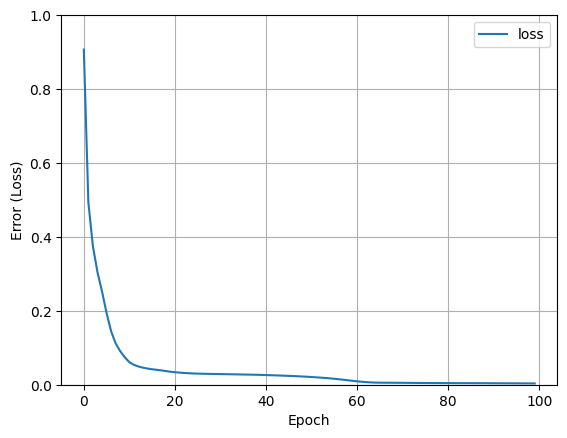

In [27]:
plot_loss(loss)

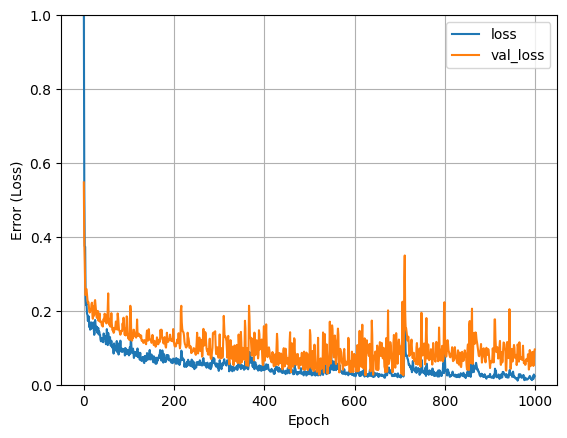

In [28]:
plot_loss(model_BPNN.history.history['loss'], model_BPNN.history.history['val_loss'])

### Inference

In [29]:
def predict(autoEncoder, BPNN, variables: list):
    """
    predict cost given economic variables

    Args:
    autoEncoder: Trained AutoEncoder model
    BPNN: Trained neural network for regression
    variables: economic variables. len(variables) = 12
    """
    features = autoEncoder.encoder(np.expand_dims(variables, axis=0))

    yhat = BPNN().predict(tf.constant(features))
    yhat = Yscaler.inverse_transform(yhat)

    return yhat

In [30]:
predict(autoEncoder, BPNN_model, X_test[-1]), Yscaler.inverse_transform(Y_test[-1][np.newaxis, :])

1/1 [==============================] - 0s 97ms/step


2022-11-24 12:36:35.499227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(array([[147681.02]], dtype=float32), array([[100000.]], dtype=float32))